In [1]:
%matplotlib inline

# Packages
import os, glob, scipy, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Project directory
base_dir = os.path.realpath('..')
print(base_dir)

# Project-specific functions
funDir = os.path.join(base_dir,'Code/Functions')
print(funDir)
sys.path.append(funDir)
import choiceModels, costFunctions, penalizedModelFit, simulateModel

# General-use python functions
dbPath = '/'.join(base_dir.split('/')[0:4])
sys.path.append('%s/Python'%dbPath)
import FigureTools

/Users/jeroen/Dropbox (Brown)/PhD/0. Working folder/HMTG_followUp_final/ShareDataCode
/Users/jeroen/Dropbox (Brown)/PhD/0. Working folder/HMTG_followUp_final/ShareDataCode/Code/Functions


## Load data

In [2]:
# Load data
clusts_all = pd.DataFrame()
sets = [[1,4],[1,6],[2,0]]
model = 'MP_ppSOE'
precision = 100
for study, baseMult in sets:
    if study == 1:
        params = pd.read_csv(os.path.join(base_dir,'Data/Study1/ComputationalModel',
               'ParamsClusters_study-%i_baseMult-%i_model-%s_precision-%i.csv'%(study,baseMult,model, precision)),index_col=0)
        params['set'] = 'Study 1, x%i-x%i-x%i'%(baseMult-2, baseMult, baseMult+2)
    elif study == 2:
        params = pd.read_csv(os.path.join(base_dir,'Data/Study2/ComputationalModel',
               'ParamsClusters_study-%i_model-%s_precision-%i.csv'%(study,model, precision)),index_col=0)
        params['set'] = 'Study 2'
    clusts_all = clusts_all.append(params[['set','sub','theta','phi','ClustName']])
clusts_all.head()

,set,sub,theta,phi,ClustName
0,"Study 1, x2-x4-x6",1,0.081617,-0.001948,MO
1,"Study 1, x2-x4-x6",2,0.497320,0.081674,GR
2,"Study 1, x2-x4-x6",3,0.054459,0.002582,MO
3,"Study 1, x2-x4-x6",4,0.101683,0.037533,IA
4,"Study 1, x2-x4-x6",5,0.024787,0.048618,IA


In [13]:
dat1 = pd.read_csv(os.path.join(base_dir,'Data/Study1/HMTG/allDataLong.csv'),header=None)
dat1.columns = ['sub','run','trial','inv','baseMult','mult','exp','ret']
subNums = np.unique(dat1['sub'])
# EXCLUDE 2 participants based on self-report (disbelief)
exclude = np.transpose(np.array(pd.read_csv(os.path.join(base_dir,'Data/Study1/HMTG/exclude.csv'),header=None,index_col=None)))[0]
non_exclude = subNums
for i in exclude:
    non_exclude = non_exclude[non_exclude!=i]
dat1 = dat1.loc[dat1['sub'].isin(non_exclude),:]
dat1 = dat1.loc[dat1['inv']>0,:]
subNums = non_exclude
clusts_all = clusts_all.loc[clusts_all['sub'].isin(subNums),:].reset_index(drop=True)
# Report
print(len(subNums))
print(len(np.unique(dat1['sub'])))
print(len(dat1.loc[(dat1['sub']==1) & (dat1['baseMult']==4),:]))
print(dat1.head())

102
102
76
   sub  run  trial  inv  baseMult  mult  exp  ret
0    1    1      1    9         4     4   18   18
1    1    1      2    6         4     6   10   10
2    1    1      3    4         4     4    5    4
3    1    1      4    5         4     2    8    2
4    1    1      5    3         4     6    2    3


In [7]:
allParams = pd.read_csv(os.path.join(base_dir,'Data/Study1/ComputationalModel/Results_study1.csv'),
                         index_col=0)
allParams.loc[allParams['baseMult']==4,'set'] = 'Study 1, x2-x4-x6'
allParams.loc[allParams['baseMult']==6,'set'] = 'Study 1, x4-x6-x8'

## Simulate model predictions and plot

In [9]:
def simulate(trials, model, theta, phi = -999):
    for ti,trial in trials.iterrows():
        trials.loc[ti,'Returned'] = model(
            trial['Investment'],trial['Multiplier'], trial['baseMult'],999,theta,phi)
    return trials

In [3]:
def plot_sub_ax(subDat,subNum,theta,phi,ax,plotLines=True):
    markers = ['^','o','v']
    handles = list()
    mults = np.sort(subDat['Multiplier'].unique())[::-1]
    for multInd,mult in enumerate(mults):
        x_dat = subDat.loc[subDat['Multiplier']==mult,'Investment']
        y_dat = subDat.loc[subDat['Multiplier']==mult,'Returned']
        handle = ax.scatter(x_dat,y_dat,c='k',marker=markers[multInd],
                            s=50,alpha=.6)
        handles.append(handle)
        if plotLines:
            lm = scipy.stats.linregress(x_dat,y_dat)
            ax.plot([0,10],[lm.intercept,lm.intercept+10*lm.slope],'k:')
    ax.set_ylim([-1,41])
    ax.set_xticks(np.arange(0,11,2))
    ax.set_yticks(np.arange(0,41,5))
    ax.legend(handles,['x%i'%mults[0],'x%i'%mults[1],'x%i'%mults[2]],loc=2,frameon=False)
    ax.set_xlabel('Investment')
    ax.set_ylabel('Returned')
    ax.set_title('Subject %i: behavior'%(subNum))

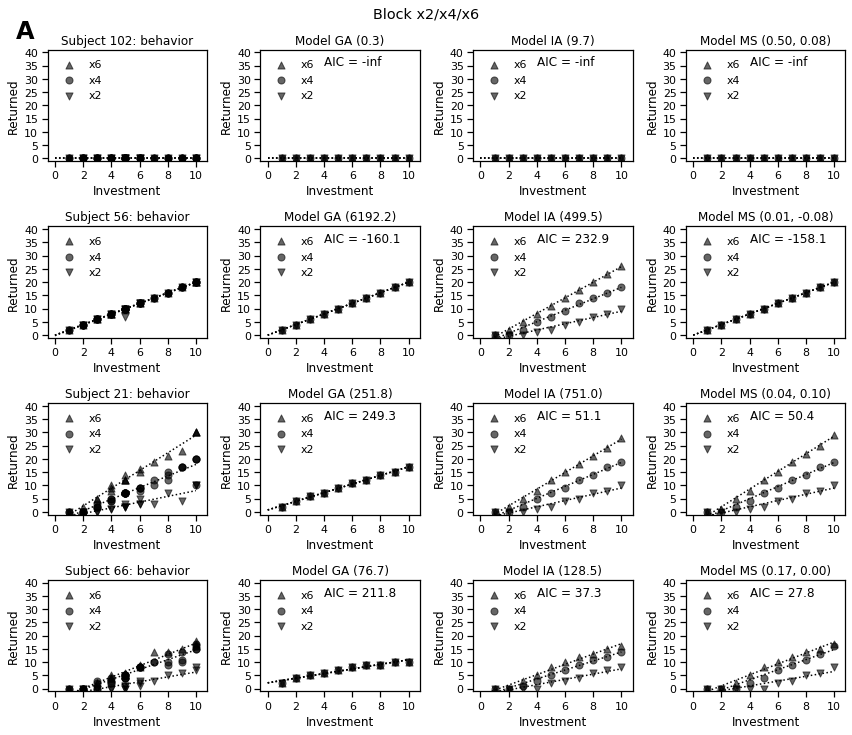

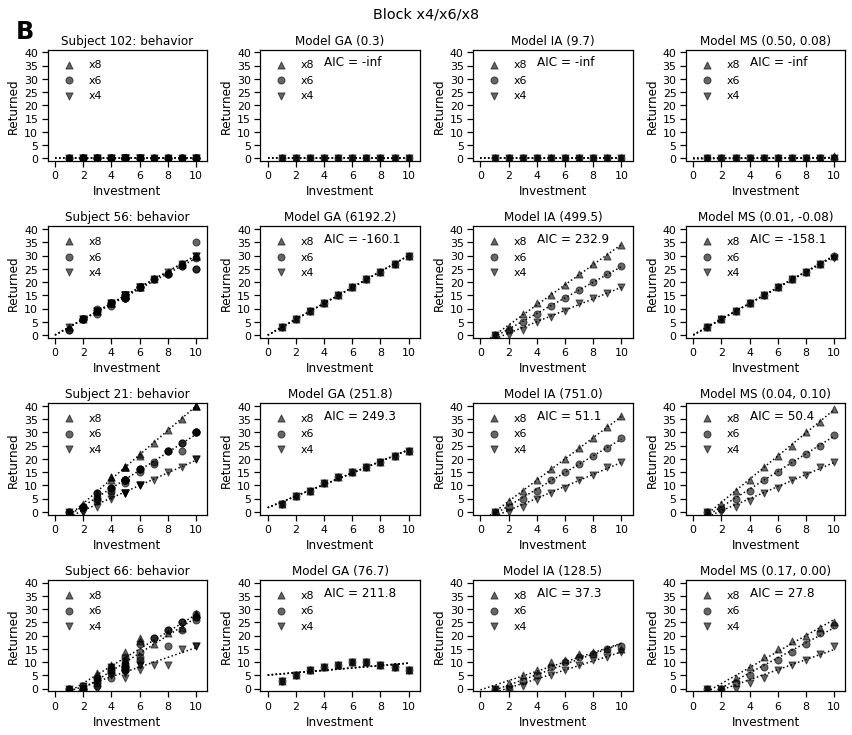

In [14]:
sns.set_context('notebook')
exemplars = [102, 56, 21, 66]
modelDict = {'GA_ppSOE':choiceModels.GA_model_ppSOE,
            'IA':choiceModels.IA_model,
            'MP_ppSOE':choiceModels.MP_model_ppSOE}
modelFancyNames = {'GA_ppSOE':'GA', 'IA':'IA', 'MP_ppSOE':'MS'}
letters = ['A','B']
for bi,baseMult in enumerate([4,6]):
    trialList = dat1.loc[dat1['baseMult']==baseMult,['baseMult','mult','inv']].drop_duplicates(
        ).sort_values(by=['mult','inv']).reset_index(drop=True).rename(
        columns={'inv':'Investment','mult':'Multiplier'})
    fig, ax = plt.subplots(4,4, figsize=[12,10])
    for si,sub in enumerate(exemplars):
        axCur = ax[si,0]
        [theta, phi] = clusts_all.loc[(clusts_all['sub']==sub) &
                                      (clusts_all['set']=='Study 1, x%i-x%i-x%i'%(baseMult-2, baseMult, baseMult+2)),
                                      ['theta','phi']].values[0]
        subDat = dat1.loc[(dat1['baseMult']==baseMult) & (dat1['sub']==sub),:].reset_index(drop=True)
        subDat = subDat.rename(columns={'inv':'Investment','mult':'Multiplier','ret':'Returned'})
        plot_sub_ax(subDat,sub,theta, phi, axCur)
        for mi,model in enumerate(['GA_ppSOE','IA','MP_ppSOE']):
            axCur = ax[si,1+mi]
            [theta, phi,SSE,AIC] = allParams.loc[(allParams['sub']==sub) & (allParams['model']==model),
                                        ['theta','phi','SSE','AIC']].values[0]
            modelDat = simulate(trialList, modelDict[model], theta, phi)
            plot_sub_ax(modelDat, sub, theta, phi, axCur)
            if model == 'MP_ppSOE':
                axCur.set(title = 'Model MS (%.2f, %.2f)'%(theta,phi))
                axCur.text(4,35,'AIC = %.1f'%AIC)
            else:
                axCur.set(title = 'Model %s (%.1f)'%(modelFancyNames[model],theta))
                axCur.text(4,35,'AIC = %.1f'%AIC)
    plt.suptitle('Block x%i/x%i/x%i'%(baseMult-2, baseMult, baseMult+2), y = 1.02)
    plt.tight_layout()
    FigureTools.add_subplot_letter(ax[0,0],letter=letters[bi])
    plt.savefig(base_dir + '/Results/Figure1_%s.pdf'%('AB'[bi]),bbox_inches='tight', transparent=True)
    plt.show()